In [1]:
import os
import mat4py
from PIL import Image
import numpy as np
import torch
from torch import optim, nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
import helper

In [2]:
root = '../datasets/PETA/PETA dataset/'

In [3]:
os.listdir(root)

['CUHK',
 'SARC3D',
 'MIT',
 'TownCentre',
 '3DPeS',
 'GRID',
 'PRID',
 'i-LID',
 'VIPeR',
 'CAVIAR4REID']

In [4]:
Labels = {}
for dir in os.listdir(root):
    labelPath = root + dir + '/archive/Label.txt'
    file = open(labelPath)
    lines = file.readlines()
    idToLabel = {}
    for line in lines:
        #line = line[0:-1]
        listOfLine = line[0:-1].split(' ')
        idToLabel[listOfLine[0].split('.')[0]] = listOfLine[1:]
    Labels[dir] = idToLabel
    

In [5]:
imgPaths = []
for subdir in os.listdir(root):
    subdir = root + subdir + '/archive/'
    #print(subdir)
    imgs = os.listdir(subdir)
    imgs.pop(imgs.index('Label.txt'))
    for i in range(len(imgs)):
        imgs[i] = subdir + imgs[i]
    imgPaths += imgs
    #print(imgs[0].split('/')[-1])
print(len(imgPaths))

19000


In [6]:
PETA_Keys = ['accessoryHeadphone', 'personalLess15', 'personalLess30', 'personalLess45', 'personalLess60', 'personalLarger60',
             'carryingBabyBuggy', 'carryingBackpack', 'hairBald', 'footwearBoots', 'lowerBodyCapri', 'carryingOther', 'carryingShoppingTro',
             'carryingUmbrella', 'lowerBodyCasual', 'upperBodyCasual', 'personalFemale', 'carryingFolder', 'lowerBodyFormal', 'upperBodyFormal',
             'accessoryHairBand', 'accessoryHat', 'lowerBodyHotPants', 'upperBodyJacket', 'lowerBodyJeans', 'accessoryKerchief', 'footwearLeatherShoes',
             'upperBodyLogo', 'hairLong', 'lowerBodyLongSkirt', 'upperBodyLongSleeve', 'lowerBodyPlaid', 'lowerBodyThinStripes', 'carryingLuggageCase',
             'personalMale', 'carryingMessengerBag', 'accessoryMuffler', 'accessoryNothing', 'carryingNothing', 'upperBodyNoSleeve', 'upperBodyPlaid',
             'carryingPlasticBags', 'footwearSandals', 'footwearShoes', 'hairShort', 'lowerBodyShorts', 'upperBodyShortSleeve', 'lowerBodyShortSkirt',
             'footwearSneakers', 'footwearStocking', 'upperBodyThinStripes', 'upperBodySuit', 'carryingSuitcase', 'lowerBodySuits', 'accessorySunglasses',
             'upperBodySweater', 'upperBodyThickStripes', 'lowerBodyTrousers', 'upperBodyTshirt', 'upperBodyOther', 'upperBodyVNeck', 'footwearBlack',
             'footwearBlue', 'footwearBrown', 'footwearGreen', 'footwearGrey', 'footwearOrange', 'footwearPink', 'footwearPurple', 'footwearRed', 
             'footwearWhite', 'footwearYellow', 'hairBlack', 'hairBlue', 'hairBrown', 'hairGreen', 'hairGrey', 'hairOrange', 'hairPink', 'hairPurple',
             'hairRed', 'hairWhite', 'hairYellow', 'lowerBodyBlack', 'lowerBodyBlue', 'lowerBodyBrown', 'lowerBodyGreen', 'lowerBodyGrey',
             'lowerBodyOrange', 'lowerBodyPink', 'lowerBodyPurple', 'lowerBodyRed', 'lowerBodyWhite', 'lowerBodyYellow', 'upperBodyBlack',
             'upperBodyBlue', 'upperBodyBrown', 'upperBodyGreen', 'upperBodyGrey', 'upperBodyOrange', 'upperBodyPink', 'upperBodyPurple',
             'upperBodyRed', 'upperBodyWhite', 'upperBodyYellow']

In [7]:
len(PETA_Keys)

105

In [8]:
class PETADataSet(Dataset):
    def __init__(self, pathOfImgs, Labels):
        self.imgs = pathOfImgs
        self.labels = Labels
        self.transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                              transforms.ToTensor()])
                                              #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
        #self.loader = loader
        #self.keys = keys
        #self.dir = dir
                                             
    def __getitem__(self, index):
        img_path = self.imgs[index]
        #print(img_path)
        img = Image.open(img_path)
        #print(img.size)
        trans = transforms.Compose([transforms.ToTensor(),])
        img = self.transforms(img)
        #print(1)
        #print(img.shape)
        img_id = img_path.split('/')[-1].split('.')[0].split('_')[0]
        img_key = img_path.split('/')[-3]
        #print(img_id, img_key)
        listOfLabels = self.labels[img_key][img_id]
        labels = [0] * len(PETA_Keys)
        for label in listOfLabels:
            if label not in PETA_Keys:
                print(label)
                continue
            labels[PETA_Keys.index(label)] = 1
        labels = torch.FloatTensor(labels)
        return (img, labels)
        
    def __len__(self):
        return len(self.imgs)

In [9]:
test_size = 0.2
totalDataSet = PETADataSet(imgPaths, Labels)
indices = list(range(len(totalDataSet)))
np.random.shuffle(indices)
cutPoint = int(np.floor(test_size * len(totalDataSet)))
train_idx, test_idx = indices[cutPoint:], indices[0:cutPoint]
trainSampler, testSampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(test_idx)
trainLoader = torch.utils.data.DataLoader(totalDataSet, batch_size=32, sampler=trainSampler)
testLoader = torch.utils.data.DataLoader(totalDataSet, batch_size=32, sampler=testSampler)
# np.random.shuffle(imgPaths)
# trainSize = 0.8
# cutPoint = int(np.floor(trainSize * len(imgPaths)))
# trainDataSet = PETADataSet(imgPaths[0: cutPoint], Labels)
# testDataSet = PETADataSet(imgPaths[cutPoint:], Labels)
# trainLoader = torch.utils.data.DataLoader(trainDataSet, batch_size=32, shuffle=True)
# testLoader = torch.utils.data.DataLoader(testDataSet, batch_size=32, shuffle=True)

In [10]:
trainIter = iter(trainLoader)
imgs, labels = trainIter.next()

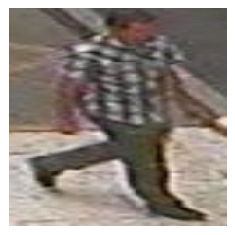

In [11]:
helper.imshow(imgs[6], normalize=False)

In [12]:
imgs.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32, 105]))

In [13]:
resnet = models.resnet18(pretrained=False)

In [14]:
#resnet50.load_state_dict(torch.load('../models/resnet50.pth'))

In [15]:
# Freeze parameters so we don't backprop through them
# for param in resnet.parameters():
#     param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 256)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(256, 128)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(128, 105)),
                          ('output', nn.Sigmoid())
                          ]))
resnet.fc = classifier

In [16]:
def errFun(res, label):
  y = label * torch.log(res) + (1-label) * torch.log(1-res)
  return -torch.sum(y) / y.numel()

In [17]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [18]:
model = resnet.to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
epoch = 3
for ep in range(epoch):
  running_err = 0
  i = 0
  for img, label in trainLoader:
    img = img.to(device)
    label = label.float().to(device)
    optimizer.zero_grad()
    output = model(img)
    err = errFun(output, label)
    err.backward()
    optimizer.step()
    running_err += err.item() * label.numel()
    i += 1
    print(i)
    if i%100 == 0:
      print(running_err / ((i+1) * 105 * len(img)))
  print('err of epoch{}: {}'.format(ep+1, running_err/(105 * len(train_idx))))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
lowerBodyLogo
19
20
21
22
23
24
25
26
accessoryShawl
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
accessoryFaceMask
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0.28183221507190476
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
accessoryFaceMask
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
lowerBodyLogo
139
140
141
142
143
144
145
146
147
148
accessoryFaceMask
149
150
151
152
153
154
155
156
157
158
accessoryFaceMask
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
accessoryShawl
lowerBodyLogo
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
lowerBodyLogo
198
199
200
0.2614381428974778
accessoryShawl
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
accessoryFaceMask
218
219
22

In [19]:
# testDataset = MyDataSet(tests, testLabels, keys, testDir)
# testLoader = torch.utils.data.DataLoader(testDataset, batch_size=32, shuffle=True)

In [20]:
testErr = 0
testAcc = 0
count = 0
for img, label in testLoader:
  img, label = img.to(device), label.to(device)
  pred = model(img)
  err = errFun(pred, label)
  testErr += err.item() * len(img)
  for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
      pred[i,j] = 1.0 if pred[i,j] > 0.5 else 0.0
  difference = torch.abs(pred - label)
  testAcc += torch.mean(torch.sum(difference, dim=0) / difference.shape[0]).item()
  count += 1
testAcc /= count
testErr /= len(test_idx)

accessoryFaceMask
accessoryFaceMask
lowerBodyLogo


In [22]:
1-testAcc, testErr

(0.9137671703801435, 0.20828116576922567)

In [23]:
torch.save(model.to(torch.device('cpu')).state_dict(), '../PETA-unPreTrainedResNet18-ep3-lr0.001.pth')